In [100]:
import sys
from pathlib import Path
import pandas as pd 
import numpy as np
from scipy.stats import pearsonr


sys.path.append(str(Path("../../..").resolve()))

from src.constants import model_data_dir

In [101]:
df_train = pd.read_csv(model_data_dir / "train_regression.csv").drop(["sc_1d_fwd_rel_ret", "mom_1d_fwd_rel_ret"], axis=1)

dates = df_train.pop("Date")

## Explore ACF

In [102]:
auto_cor = [{"lag": lag, "corr": df_train["value_1d_fwd_rel_ret"].autocorr(lag)} for lag in range(1, 90)]
pd.DataFrame(auto_cor).sort_values("corr", ascending=False).head()

,lag,corr
19,20,0.056040
21,22,0.053327
12,13,0.051467
2,3,0.051342
15,16,0.046260


In [103]:
def cross_corr(df, target, col, lag):
    if col not in ["Date", "value_1d_fwd_rel_ret"]:
        try:
            return pearsonr(df[target][lag:], df[col].shift(lag)[lag:])[0]
        except:
            return np.nan
    
    return np.nan
            
def cross_corrs(df = df_train, target = "value_1d_fwd_rel_ret", lag = 1):
    corr_dict= {}
    for col in df.columns.tolist():
        corr_dict[col] = cross_corr(df, target, col, lag)
    return corr_dict

In [104]:
corrs = pd.DataFrame([cross_corrs(df_train, "value_1d_fwd_rel_ret", lag) 
                            for lag in range(1, 91)])
corrs

,S&P 500,MSCI DM,MSCI EM,WTI Crude Oil,S&P GSCI,Gold,Global Inflation-linked debt,iTraxx Europe 5Yr,iTraxx Crossover 5Yr,CDX IG 5Yr,...,S&P 500 Price-to-Earnings,P/B,US Value P/E over Growth P/E,US Value P/B over Growth P/B,EquityBond premia,S&P 500 Skew,EURUSD Risk Reversal,USDJPY Risk Reversal,EURJPY Risk Reversal,value_1d_fwd_rel_ret
0,-0.001791,0.024310,-0.004278,0.003220,0.005690,-0.018223,0.003426,0.023645,0.021940,0.007421,...,0.000697,-0.000435,0.004679,0.008743,0.005561,-0.040502,-0.006856,0.000163,0.005864,NaN
1,-0.020198,0.019017,0.009857,-0.006316,-0.007211,-0.008284,0.008718,0.005039,0.006564,-0.012664,...,0.019590,0.018832,0.020676,0.023944,0.022479,-0.026261,-0.013529,0.001622,0.016281,NaN
2,-0.009689,0.010042,0.015068,0.001296,0.006877,0.018172,-0.009781,0.010069,0.006550,0.006034,...,-0.011901,-0.012681,-0.009722,-0.005653,-0.008265,-0.016029,-0.020498,0.011841,-0.026450,NaN
3,-0.000812,-0.011267,-0.014605,-0.008305,-0.008177,-0.004890,0.004469,-0.007786,-0.007382,-0.012885,...,-0.006079,-0.005917,-0.009803,-0.007088,-0.006716,-0.016632,0.000926,-0.009298,0.003304,NaN
4,0.004874,0.006435,-0.006823,-0.034858,0.010687,0.011904,0.032806,-0.008571,-0.009801,0.008530,...,0.010521,0.010755,0.005617,0.007537,0.008927,0.000536,-0.035157,0.003380,-0.007627,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,-0.004647,-0.002569,-0.027556,-0.007284,-0.005817,0.002651,-0.016512,0.035099,0.035113,-0.011953,...,0.017118,0.017254,0.016147,0.014961,0.016029,-0.000854,0.010375,0.009215,-0.001321,NaN
86,-0.012092,-0.012238,-0.007414,-0.018261,0.014546,-0.017240,-0.029437,0.004560,0.002590,0.001557,...,-0.027377,-0.027190,-0.028319,-0.027018,-0.027381,0.016373,-0.004096,0.004648,0.021530,NaN
87,-0.011883,-0.005793,-0.014724,-0.027330,0.001131,-0.011566,-0.008434,-0.000375,-0.001547,-0.003206,...,-0.034099,-0.035793,-0.019325,-0.018635,-0.025903,-0.030141,-0.010739,-0.008462,0.003165,NaN
88,0.003572,-0.017706,0.020161,-0.012133,-0.000458,0.018754,0.027026,-0.000342,-0.001602,0.007790,...,0.006856,0.006416,0.008473,0.010502,0.009025,0.001901,-0.001325,0.012471,0.004735,NaN


## Feature selection

In [105]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import RidgeCV

y_train, x_train = df_train.pop("value_1d_fwd_rel_ret"), df_train

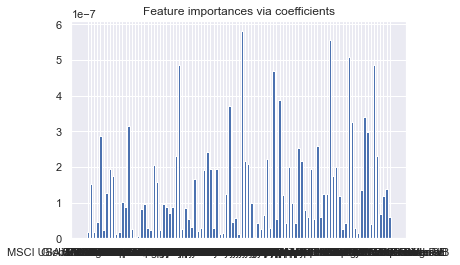

In [106]:
ridge_fit = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(x_train, y_train)
importance = np.abs(ridge_fit.coef_)
feature_names = np.array(x_train.columns)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

### Sequential selection

In [107]:
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
sfs_forward = SequentialFeatureSelector(
    ridge_fit, n_features_to_select=15, direction="forward"
).fit(x_train, y_train)

In [108]:
feature_names[sfs_forward.get_support()]

array(['S&P GSCI', 'CDX IG 5Yr', 'High Yield Spread',
       'US HY over IG CDS spread', 'IWF',
       'MSCI USA Sector Neutral Quality Index                                                  ',
       'GBP/USD Carry', 'NZD/USD Carry', 'JPM Global FX Vol',
       'JPM EM FX Vol', 'Ted Spread',
       'GTDEM3MO Corp                                                   ',
       'GTITL3MO Corp                                                   ',
       'GTJPY10YR Corp                                                  ',
       'US Value P/B over Growth P/B'], dtype=object)

### Feature selection based on importance

In [109]:
sfm = SelectFromModel(ridge_fit, threshold=np.sort(importance)[-15]).fit(x_train, y_train)
feature_names[sfm.get_support()]

array(['S&P GSCI', 'High Yield Spread',
       'MSCI USA Sector Neutral Quality Index                                                  ',
       'US Economic Activity Surprise', 'V2X', 'USDJPY 1M Vol',
       'Ted Spread',
       'GTCAD10YR Corp                                                  ',
       'GTDEM10YR Corp                                                  ',
       'GTJPY10YR Corp                                                  ',
       'GDP Libor', 'Fed Target Rate', 'S&P 500 Price-to-Earnings', 'P/B',
       'US Value P/B over Growth P/B'], dtype=object)

## Prophet

In [110]:
from fbprophet import Prophet
selected_vars = feature_names[sfs_forward.get_support()]
m = Prophet(growth = "logistic", weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=True,)
for var in selected_vars:
    m.add_regressor(var)

In [111]:
df_train["Date"] = dates
df_train["value_1d_fwd_rel_ret"] = y_train
df_model = df_train.rename(columns={"Date": "ds", "value_1d_fwd_rel_ret": "y"})

In [112]:
m.fit(df_model)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/qiushi/workspace/dsi-courses/APlusBernstein-Project/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -41.4682


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5481.68   2.45862e-05       85.0456      0.4598      0.4598      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       5481.78   0.000480093        92.777    5.24e-06       0.001      197  LS failed, Hessian reset 
     167       5481.81   1.25311e-05       70.9863   1.458e-07       0.001      281  LS failed, Hessian reset 
     179       5481.81   2.53784e-07       58.3799      0.2349           1      297   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [113]:
df_test = pd.read_csv(model_data_dir / "test_regression.csv")[["Date", "value_1d_fwd_rel_ret"] + selected_vars.tolist()].rename({"Date": "ds"}, axis=1)


/Users/qiushi/workspace/dsi-courses/APlusBernstein-Project/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/qiushi/workspace/dsi-courses/APlusBernstein-Project/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


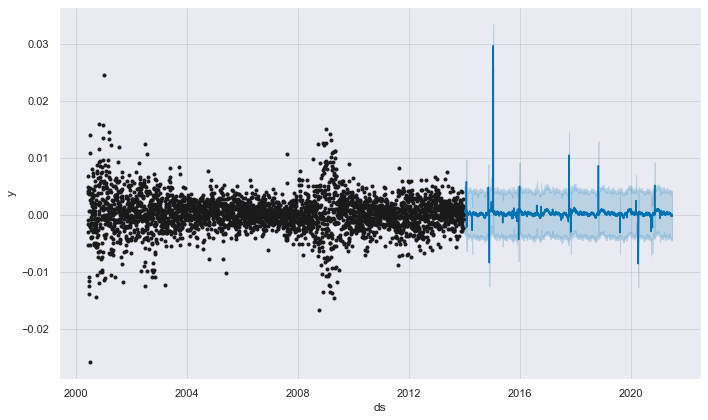

In [114]:
forecast = m.predict(df_test)
fig1 = m.plot(forecast)

<AxesSubplot:xlabel='ds', ylabel='price'>

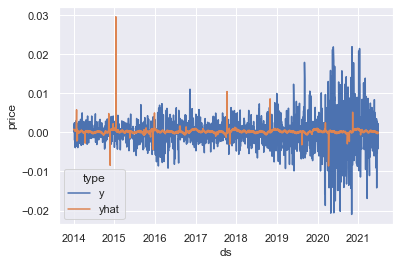

In [115]:
import seaborn as sns
sns.set_theme(style="darkgrid")

plot_data = forecast.assign(y = df_test["value_1d_fwd_rel_ret"])[["ds", "y", "yhat"]].melt(id_vars="ds", var_name="type", value_name="price")

# Plot the responses for different events and regions
sns.lineplot(x="ds", y="price",
             hue="type",
             data=plot_data)

/Users/qiushi/workspace/dsi-courses/APlusBernstein-Project/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/qiushi/workspace/dsi-courses/APlusBernstein-Project/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


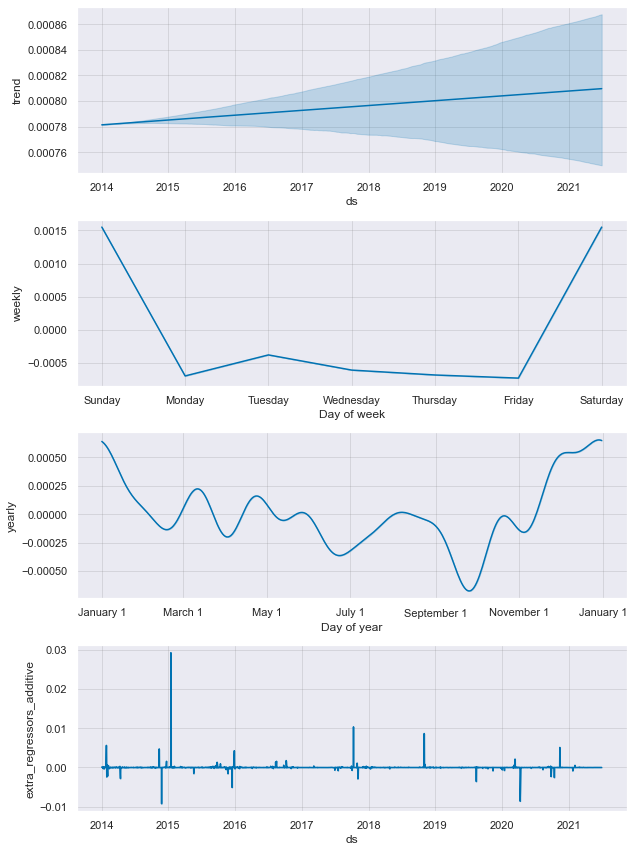

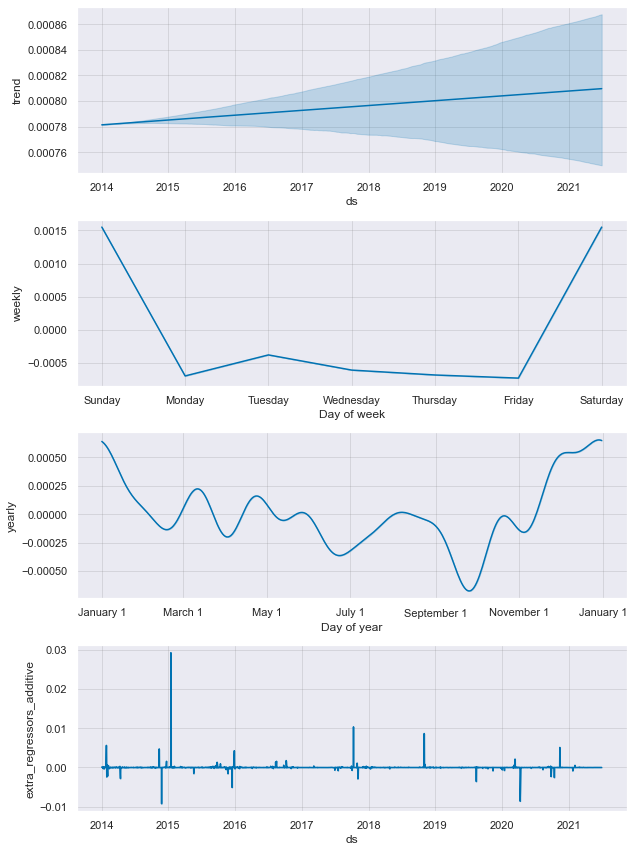

In [116]:
m.plot_components(forecast)